---
##### Import Necessary Libraries and Setup Device
---

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# 1. Device Setup: This makes the code work for the whole team
if torch.backends.mps.is_available():
    device = torch.device("mps") # Mac M2
    print("Device: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda") # Windows (if NVIDIA GPU exists)
    print("Device: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")  # Intel Mac / standard Windows
    print("Device: CPU")

# 2. Path Standardization
# Using os.path.join ensures paths work on both Windows (\) and Mac (/)
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed_dataset")

print(f"Project Directory: {BASE_DIR}")

Device: Apple Silicon GPU (MPS)
Project Directory: /Users/galohsafiya/Documents/Year 3 Sem 2/Visual Image Processing/VIP-Project-main


---
##### Data Architecture & Cleaning
---

In [ ]:
# 1. Path Configuration
# Use relative paths for better portability
RAW_DATA_PATH = "/Users/galohsafiya/Documents/Year 3 Sem 2/Visual Image Processing/Project-2530/Project Code/Dataset"
PROCESSED_PATH = os.path.join("dataset_final")

def organize_and_clean(src, dst):
    categories = ['Fresh', 'Rotten']
    for cat in categories:
        os.makedirs(os.path.join(dst, cat), exist_ok=True)

    MAX_IMAGES_PER_FRUIT = 3000 
    fruit_tracker = {} 

    print(f"Starting balanced cleaning and merging from: {src}")
    stats = {"Fresh": 0, "Rotten": 0, "Skipped": 0, "Capped": 0}

    for root, dirs, files in os.walk(src):
        # Determine the label by looking at the full path string
        path_lower = root.lower()
        
        # Skip the root directory and only look for folders with 'fresh' or 'rotten'
        if 'fresh' in path_lower:
            current_label = 'Fresh'
        elif 'rotten' in path_lower:
            current_label = 'Rotten'
        else:
            continue # If the folder doesn't say fresh or rotten, ignore it

        # Use the folder name to track the specific fruit (e.g., 'apple')
        fruit_name = os.path.basename(root).lower()
        if fruit_name not in fruit_tracker:
            fruit_tracker[fruit_name] = 0

        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(root, file)
                
                try:
                    if os.path.getsize(src_path) <= 0:
                        stats["Skipped"] += 1
                        continue
                    
                    if fruit_tracker[fruit_name] >= MAX_IMAGES_PER_FRUIT:
                        stats["Capped"] += 1
                        continue
                    
                    unique_name = f"{fruit_name}_{file}"
                    dst_path = os.path.join(dst, current_label, unique_name)
                    
                    shutil.copy2(src_path, dst_path)
                    
                    fruit_tracker[fruit_name] += 1
                    stats[current_label] += 1
                    
                except (OSError, IOError):
                    stats["Skipped"] += 1
                    continue

    print("\n--- Corrected Data Summary ---")
    print(f"Fresh Images: {stats['Fresh']}")
    print(f"Rotten Images: {stats['Rotten']}")
    print(f"Files Capped: {stats['Capped']}")
    print(f"Files Skipped: {stats['Skipped']}")

organize_and_clean(RAW_DATA_PATH, PROCESSED_PATH)

Starting balanced cleaning and merging from: /Users/galohsafiya/Documents/Year 3 Sem 2/Visual Image Processing/Project-2530/Project Code/Dataset

--- Corrected Data Summary ---
Fresh Images: 21025
Rotten Images: 20194
Files Capped: 30084
Files Skipped: 0


---
##### Data Augmentation
---

In [4]:
import numpy as np
from torch.utils.data import WeightedRandomSampler, Subset

# 1. Transform setup (remains the same)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Load the full dataset
full_dataset = datasets.ImageFolder(PROCESSED_PATH, transform=transform)

# 3. Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

# 4. Technical Component: Fixed Weighted Sampling
# We calculate weights ONLY for the training subset to avoid IndexError
train_labels = [full_dataset.targets[i] for i in train_indices]
class_sample_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_labels])
sampler = WeightedRandomSampler(torch.from_numpy(samples_weight).type(torch.DoubleTensor), len(samples_weight))

# 5. Create the Subset objects
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)

# 6. Create Loaders
# num_workers=0 is best for 8GB RAM to prevent memory spikes
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)

print(f"Fixed Sampler for Training: {len(train_data)} images")
print(f"Validation Set: {len(val_data)} images")

Fixed Sampler for Training: 32975 images
Validation Set: 8244 images


---
##### Model Training (MobileNetV2)
---

In [5]:
# 1. Load Pre-trained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# 2. Freeze the backbone (Feature Extractor)
# Technical Component: Transfer Learning
for param in model.parameters():
    param.requires_grad = False

# 3. Modify Classifier for Binary Freshness Detection
model.classifier[1] = nn.Sequential(
    nn.Linear(model.last_channel, 128),
    nn.ReLU(),
    nn.Dropout(0.3), 
    nn.Linear(128, 2) 
)

# 4. Move model to M2 GPU
model = model.to(device)

# 5. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# 6. Training Loop
num_epochs = 5 
train_losses, train_accs = [], []

print(f"Training MobileNetV2 on {device}...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # tqdm progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_data)
    
    # Use .float() instead of .double() to satisfy the MPS framework
    epoch_acc = running_corrects.float() / len(train_data)
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item()) # .item() handles the move to CPU automatically
    
    print(f"Epoch {epoch+1} Complete: Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# 7. Save weights for the final application
torch.save(model.state_dict(), 'mobilenet_freshness.pth')
print("Model weights saved to 'mobilenet_freshness.pth'")

Training MobileNetV2 on mps...


Epoch 1/5:  21%|██        | 213/1031 [01:16<04:27,  3.05it/s]/opt/miniconda3/envs/vip/lib/python3.10/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/5: 100%|██████████| 1031/1031 [06:25<00:00,  2.68it/s] 


Epoch 1 Complete: Loss: 0.3061 | Accuracy: 0.8707


Epoch 2/5: 100%|██████████| 1031/1031 [08:33<00:00,  2.01it/s] 


Epoch 2 Complete: Loss: 0.2279 | Accuracy: 0.9079


Epoch 3/5: 100%|██████████| 1031/1031 [07:43<00:00,  2.22it/s] 


Epoch 3 Complete: Loss: 0.2019 | Accuracy: 0.9199


Epoch 4/5: 100%|██████████| 1031/1031 [05:46<00:00,  2.98it/s]


Epoch 4 Complete: Loss: 0.1833 | Accuracy: 0.9289


Epoch 5/5: 100%|██████████| 1031/1031 [05:34<00:00,  3.09it/s]


Epoch 5 Complete: Loss: 0.1650 | Accuracy: 0.9363
Model weights saved to 'mobilenet_freshness.pth'


In [8]:
# 1. Re-initialize the Model Structure
model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.last_channel, 128),
    nn.ReLU(),
    nn.Dropout(0.4), 
    nn.Linear(128, 2) 
)

# 2. Load Existing Weights (Warm Start)
try:
    model.load_state_dict(torch.load('mobilenet_freshness.pth'))
    print("Successfully loaded 'mobilenet_freshness.pth'. Starting refinement...")
except FileNotFoundError:
    print("Weights file not found. Ensure the path is correct or train from scratch.")

model = model.to(device)

# 3. Technical Component: Weighted Loss (Slide 82 & 81)
# We apply a 2.5x weight to the 'Rotten' class (index 1) to penalize False Fresh errors.
# This forces the model to be more sensitive to subtle signs of decay.
class_weights = torch.tensor([1.0, 2.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 4. Optimizer with Lower Learning Rate (Slide 79)
# Use a 10x smaller learning rate to avoid 'breaking' previous learning
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# 5. Refinement Training Loop
num_epochs = 3 # Short duration is enough for refinement
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(train_loader, desc=f"Refinement Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.float() / len(train_data)
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    print(f"Refinement Epoch {epoch+1} Complete: Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# 6. Save as the Safety-Optimized Version
torch.save(model.state_dict(), 'MobilenetV2_galoh_final.pth')
print("Safety-optimized model saved as 'MobilenetV2_galoh_final.pth'")

Successfully loaded 'mobilenet_freshness.pth'. Starting refinement...


Refinement Epoch 1/3:  11%|█▏        | 116/1031 [02:39<15:53,  1.04s/it]/opt/miniconda3/envs/vip/lib/python3.10/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Refinement Epoch 1/3: 100%|██████████| 1031/1031 [16:45<00:00,  1.02it/s] 


Refinement Epoch 1 Complete: Loss: 0.1120 | Accuracy: 0.9480


Refinement Epoch 2/3: 100%|██████████| 1031/1031 [14:19<00:00,  1.20it/s]


Refinement Epoch 2 Complete: Loss: 0.0790 | Accuracy: 0.9648


Refinement Epoch 3/3: 100%|██████████| 1031/1031 [15:42<00:00,  1.09it/s]


Refinement Epoch 3 Complete: Loss: 0.0589 | Accuracy: 0.9728
Safety-optimized model saved as 'MobilenetV2_galoh_final.pth'


Running Final Evaluation...

 Classification Report:
              precision    recall  f1-score   support

       Fresh       0.99      0.97      0.98      4177
      Rotten       0.97      0.99      0.98      4067

    accuracy                           0.98      8244
   macro avg       0.98      0.98      0.98      8244
weighted avg       0.98      0.98      0.98      8244



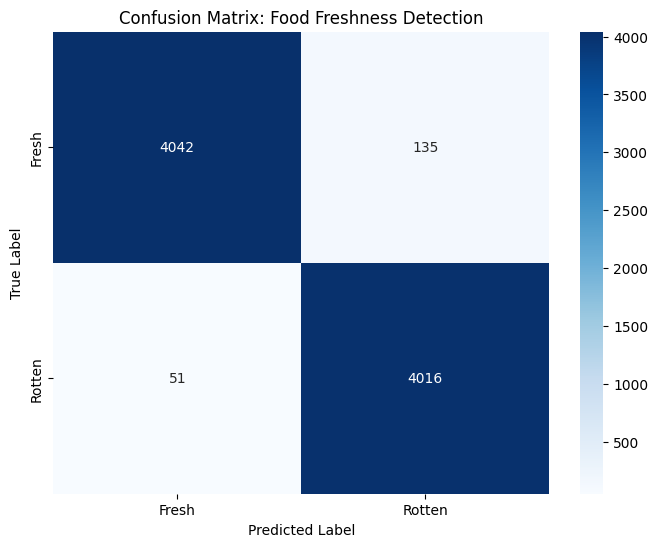

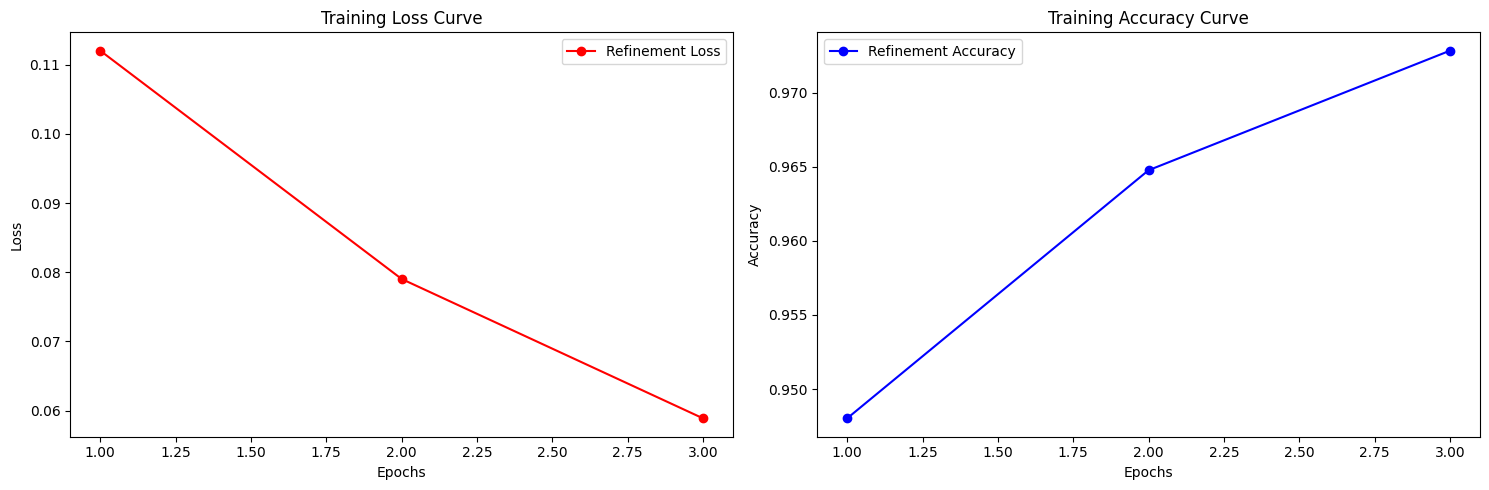

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def evaluate_model(model, test_loader, device, classes=['Fresh', 'Rotten']):
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Running Final Evaluation...")
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 1. Quantitative Metrics
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\n Classification Report:")
    print(report)

    # 2. Visualization: Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix: Food Freshness Detection')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 3. Visualization: Training Progress
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(epochs, train_losses, 'r-o', label='Refinement Loss')
    ax1.set_title('Training Loss Curve')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy Curve
    ax2.plot(epochs, train_accs, 'b-o', label='Refinement Accuracy')
    ax2.set_title('Training Accuracy Curve')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# 4. Execute Evaluation
evaluate_model(model, val_loader, device)